In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from scipy import stats

# For displaying all columns in outputs
pd.set_option('display.max_columns', None)

# Load the dataset
url = 'https://raw.githubusercontent.com/krishna-koly/IMDB_TOP_1000/refs/heads/main/imdb_top_1000.csv'
df = pd.read_csv(url)

# Basic overview
print("Data Shape:", df.shape)
df.head()


Data Shape: (1000, 16)


,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,"28,341,469"
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"


Step 1:
DATA CLEANING

We will use two strategies for handling missing values:
1. Dropping missing values
2. Imputing missing values

In [4]:

# Count missing values by column
#missing_counts = df.isnull().sum().sort_values(ascending=False)
#print(missing_counts)

# Strategy 1

#print("Initial number of rows: ", df.shape[0])

#df = df.dropna(subset=['IMDB_Rating'])

#print("Rows after dropping: ", df.shape[0])

In [5]:
# Strategy 2

df['Meta_score'] = pd.to_numeric(df['Meta_score'], errors='coerce')

print("Missing Meta_scores: ", df['Meta_score'].isnull().sum())

imputer = SimpleImputer(strategy='median')
df['Meta_score'] = imputer.fit_transform(df[['Meta_score']])

print("Missing Meta_scores after imputation: ", df['Meta_score'].isnull().sum())

Missing Meta_scores:  157
Missing Meta_scores after imputation:  0


The strategies applied work like this:
1. Drops all movies that do not have an IMDB Rating, justified by the fact that we do not know how they got in the top 1000 without their rating
2. Imputing Meta_score with the median of all the other movies.

The second strategy makes more sense in this case because there are no movies that do not have an IMDB Rating in this list, and the Meta_score that gets added to each movie should be pretty close to its real value because all the movies in the top 1000 should have a similar Meta_score 

Detecting and addressing outliers:

Common numeric features here might include: <br>
IMDB_Rating should be mostly 1-10 <br>
Meta_score 0-100 <br>
No_of_Votes <br>
Gross (in dollars)

In [6]:
# Convert Gross to numeric

df['Gross'] = df['Gross'].replace(r'[\$,]', '', regex=True).astype(float)
df['Meta_score'] = pd.to_numeric(df['Meta_score'], errors='coerce')

numeric_cols = ['IMDB_Rating', 'Meta_score', 'No_of_Votes', 'Gross']

We will use a boxplot to get a quick visual check on potential outliers

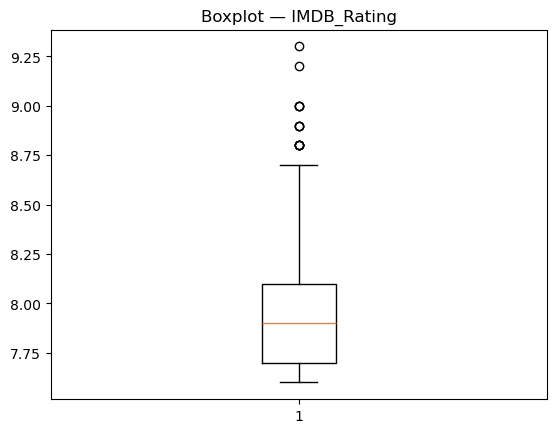

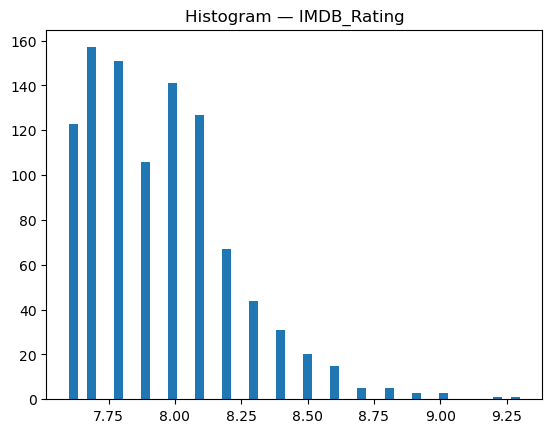

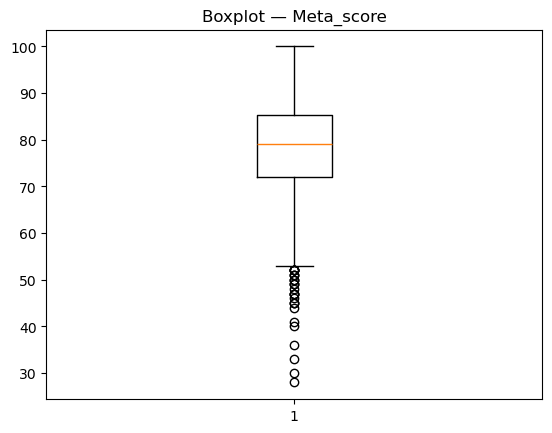

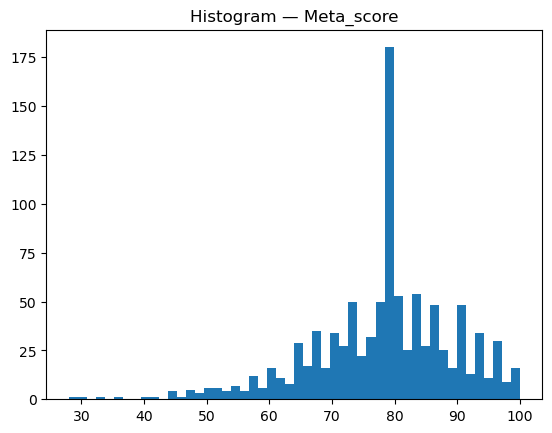

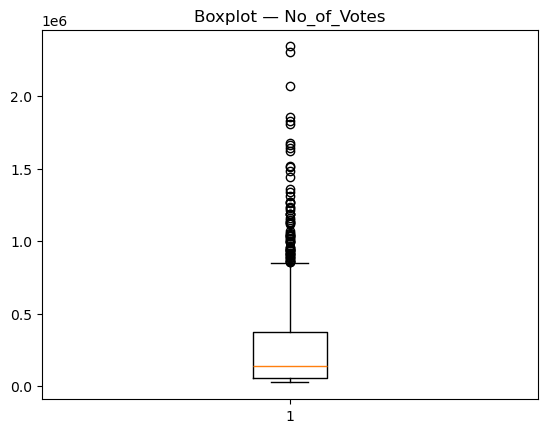

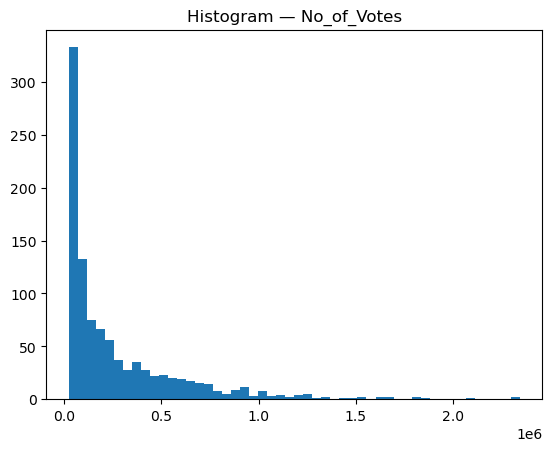

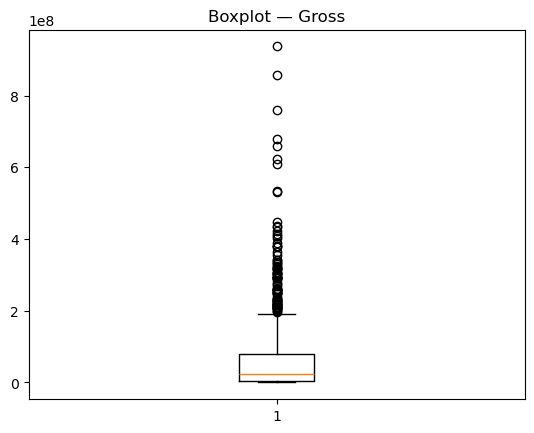

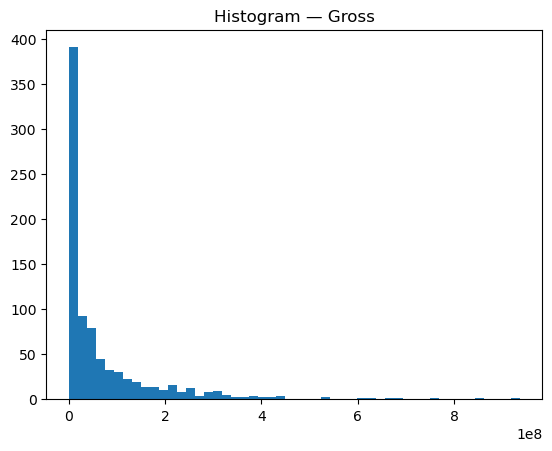

In [7]:
for col in numeric_cols:
    plt.figure()
    plt.title(f"Boxplot — {col}")
    plt.boxplot(df[col].dropna())
    plt.show()

    plt.figure()
    plt.title(f"Histogram — {col}")
    plt.hist(df[col].dropna(), bins=50)
    plt.show()

In [8]:
# IQR-based detection function

def iqr_outlier_bounds(series):
    Q1, Q3 = series.quantile([.25,.75])
    IQR = Q3 - Q1
    return (Q1 - 1.5*IQR, Q3 + 1.5*IQR)

outlier_report = []
for col in numeric_cols:
    s = df[col].dropna()
    lower, upper = iqr_outlier_bounds(s)
    mask = (s < lower) | (s > upper)
    outlier_report.append({
        'feature': col,
        'n_outliers': mask.sum(),
        'pct_outliers': mask.mean()*100,
        'lower_bound': lower,
        'upper_bound': upper,
        'skewness': s.skew()
    })
    
pd.DataFrame(outlier_report).set_index('feature')


,n_outliers,pct_outliers,lower_bound,upper_bound,skewness
feature,,,,,
IMDB_Rating,13,1.300000,7.100000e+00,8.700000e+00,1.016964
Meta_score,31,3.100000,5.212500e+01,1.051250e+02,-0.700505
No_of_Votes,67,6.700000,-4.224262e+05,8.521138e+05,2.300011
Gross,89,10.709988,-1.129924e+08,1.969969e+08,3.130134


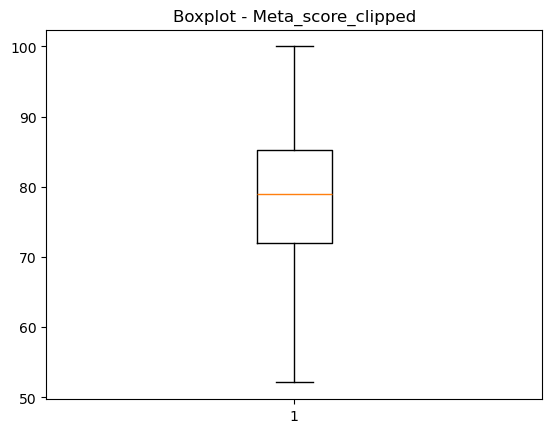

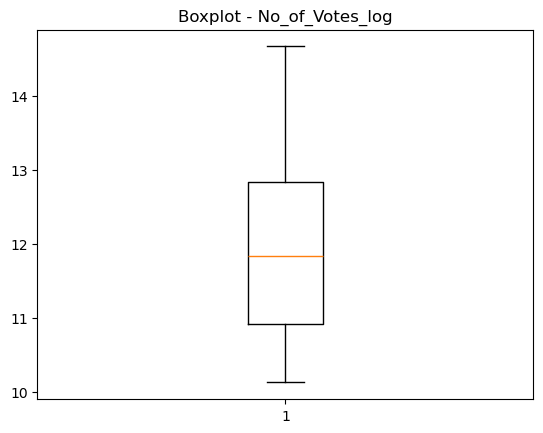

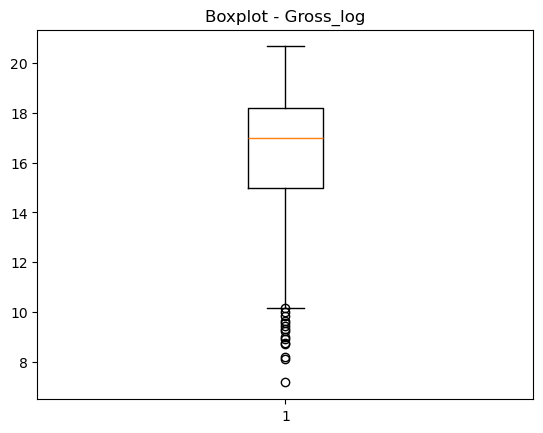

In [9]:
lower, upper = iqr_outlier_bounds(df['Meta_score'].dropna())
df['Meta_score_clipped'] = df['Meta_score'].clip(lower, upper)

df['No_of_Votes_log'] = np.log1p(df['No_of_Votes'])
df['Gross_log'] = np.log1p(df['Gross'])

for col in ['Meta_score_clipped', 'No_of_Votes_log', 'Gross_log']:
    plt.figure()
    plt.title(f"Boxplot - {col}")
    plt.boxplot(df[col].dropna())
    plt.show()

Identifying and fixing inconsistencies:

In [10]:
# Genre: lower every case + strip whitespaces
df['Genre'] = df['Genre'].astype(str).str.lower().str.strip()

# Certificate: up every case, fix common typos
df['Certificate'] = df['Certificate'].astype(str).str.upper().str.strip()
df['Certificate'] = df['Certificate'].replace({
    'PG13': 'PG-13',
    'PG 13': 'PG-13',
    'NOT RATED': 'Not Rated',
    'NR' : 'Not Rated',
    'UNRATED': 'Not Rated' 
})

# Drop duplicates on movie title(if any)
df = df.drop_duplicates(subset='Series_Title')

# Direct & Stars: strip extra whitespace
for col in ['Director', 'Star1', 'Star2', 'Star3', 'Star4']:
    df[col] = df[col].astype(str).str.strip()

# Runtime: remove 'min' suffix -> integer minutes
df['Runtime'] = df['Runtime'].str.extract(r'(\d+)').astype(float).astype('Int64')

# Released_Year: ensure integer type
df['Released_Year'] = pd.to_numeric(df['Released_Year'], errors='coerce').astype('Int64')

# Ensure all numeric columns are numeric
for col in ['IMDB_Rating', 'Meta_score', 'No_of_Votes', 'Gross']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Check for impossible rating values and drop if any
invalid = df[(df['IMDB_Rating'] < 1) | (df['IMDB_Rating'] > 10)]
if not invalid.empty:
    print("Dropping rows with invalid IMDb ratings: ", invalid.shape[0])
    df = df.drop(invalid.index)

# Final check for missing numeric after coercion
print("Missing counts after cleaning:\n", df[numeric_cols].isnull().sum())


Missing counts after cleaning:
 IMDB_Rating      0
Meta_score       0
No_of_Votes      0
Gross          169
dtype: int64


As you can see we only have missing values in the Gross section which is not as important as the other ones, so we can actually ignore it.

Step 2: DATA TRANSFORMATION

Normalizing and standardizing numerical features <br>
We are going to use these 3 preprocessing tools: <br>
1. Z-Score(StandardScaler) <br>
2. MinMaxScaler <br>
3. LabelEncoder


In [11]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

df_transformed = df.copy()

# Z-Score scale for roughly symmetric features
std_cols = ['IMDB_Rating', 'Meta_score_clipped']
scaler = StandardScaler()
df_transformed[[f"{c}_std" for c in std_cols]] = scaler.fit_transform(df_transformed[std_cols])

# Min-Max scale for skewed numeric features
norm_cols = ['No_of_Votes', 'Gross']
minmax = MinMaxScaler()
df_transformed[[f"{c}_norm" for c in norm_cols]] = minmax.fit_transform(df_transformed[norm_cols])

# Label-encode key categorical columns
for col in ['Genre', 'Certificate']:
    le = LabelEncoder()
    df_transformed[f"{col}_enc"] = le.fit_transform(df_transformed[col].astype(str))

df_transformed.head()

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,Meta_score_clipped,No_of_Votes_log,Gross_log,IMDB_Rating_std,Meta_score_clipped_std,No_of_Votes_norm,Gross_norm,Genre_enc,Certificate_enc
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142,drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,28341469.0,80.0,14.666990,17.159837,4.905826,0.155456,1.000000,0.030257,137,1
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175,"crime, drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.0,100.0,14.298164,18.720537,4.542687,2.003030,0.688207,0.144092,122,1
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152,"action, crime, drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.0,84.0,14.649824,20.097513,3.816409,0.524971,0.982797,0.571025,22,16
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974,A,202,"crime, drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000.0,90.0,13.937687,17.863811,3.816409,1.079243,0.476641,0.061173,122,1
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96,"crime, drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,4360000.0,96.0,13.444224,15.287983,3.816409,1.633516,0.286778,0.004653,122,14


Step 3: DATA REDUCTION <br>
We will remove redundant features via correlation, identify features with a high correlation and drop them

In [12]:
import pandas as pd
import numpy as np

# Identify Numeric Columns
numeric_cols = df_transformed.select_dtypes(include=['float64','int64']).columns.tolist()

# Correlation-Based Redundancy Check
corr_matrix = df_transformed[numeric_cols].corr().abs()

# Only consider upper triangle to avoid duplicates
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Drop columns with correlation > 0.80
high_corr = [col for col in upper_tri.columns if any(upper_tri[col] > 0.80)]
df_reduced = df_transformed.drop(columns=high_corr)

print("Dropped due to high correlation:", high_corr)

# Domain-Based Removal of Irrelevant Columns
# Example: If 'Poster_Link' or 'Overview' is not relevant for modeling, we drop them
irrelevant_cols = ['Poster_Link','Overview']  # adjust as needed
df_reduced = df_reduced.drop(columns=[c for c in irrelevant_cols if c in df_reduced.columns], errors='ignore')

print("Dropped due to irrelevance:", irrelevant_cols)

# Check Final Shape
print("Shape before reduction:", df_transformed.shape)
print("Shape after reduction:", df_reduced.shape)

# Preview the Reduced Data
df_reduced.head()


Dropped due to high correlation: ['Meta_score_clipped', 'No_of_Votes_log', 'IMDB_Rating_std', 'Meta_score_clipped_std', 'No_of_Votes_norm', 'Gross_norm']
Dropped due to irrelevance: ['Poster_Link', 'Overview']
Shape before reduction: (999, 25)
Shape after reduction: (999, 17)


,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,Gross_log,Genre_enc,Certificate_enc
0,The Shawshank Redemption,1994,A,142,drama,9.3,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,28341469.0,17.159837,137,1
1,The Godfather,1972,A,175,"crime, drama",9.2,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.0,18.720537,122,1
2,The Dark Knight,2008,UA,152,"action, crime, drama",9.0,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.0,20.097513,22,16
3,The Godfather: Part II,1974,A,202,"crime, drama",9.0,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000.0,17.863811,122,1
4,12 Angry Men,1957,U,96,"crime, drama",9.0,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,4360000.0,15.287983,122,14


Step 4: FEATURE ENGINEERING


In [13]:
import matplotlib.pyplot as plt

# --- 1. Copy data and handle missing values ---
df = df_transformed.copy()
df['Gross'] = df['Gross'].fillna(df['Gross'].median())

# --- 2. Create New Features ---
df['Movie_Age']          = 2025 - df['Released_Year']
df['Rating_Votes_Ratio'] = df['IMDB_Rating'] / (df['No_of_Votes'] + 1)
df['Gross_per_Vote']     = df['Gross'] / (df['No_of_Votes'] + 1)
df['Votes_per_Year']     = df['No_of_Votes'] / (df['Movie_Age'] + 1)
df['Runtime_per_Rating'] = df['Runtime'] / (df['IMDB_Rating'] + 0.001)
df['Is_Blockbuster']     = (df['Gross'] > df['Gross'].quantile(0.75)).astype(int)
df['Decade']             = (df['Released_Year'] // 10) * 10

# --- 3. Examine Correlations with IMDb Rating ---
# List the engineered features we want to evaluate:
engineered_features = ['Movie_Age', 'Rating_Votes_Ratio', 'Gross_per_Vote', 
                       'Votes_per_Year', 'Runtime_per_Rating', 'Is_Blockbuster']

# Compute correlations (absolute values)
correlations = df[engineered_features + ['IMDB_Rating']].corr()['IMDB_Rating'].abs().drop('IMDB_Rating')
print("Correlation of engineered features with IMDb_Rating:")
print(correlations)

# --- 4. Drop the Least-Correlated Feature ---
# For simplicity, let's drop the feature with the smallest correlation.
least_important = correlations.idxmin()
print(f"\nDropping the least correlated feature: {least_important}")
df_final = df.drop(columns=[least_important])

# --- 5. Preview the Final Dataset ---
df_final.head()
df = df_final.copy()

Correlation of engineered features with IMDb_Rating:
Movie_Age             0.132107
Rating_Votes_Ratio    0.157117
Gross_per_Vote        0.192198
Votes_per_Year        0.290917
Runtime_per_Rating    0.088805
Is_Blockbuster        0.045633
Name: IMDB_Rating, dtype: float64

Dropping the least correlated feature: Is_Blockbuster


Extracting & Visualizing Insights

Insight 1


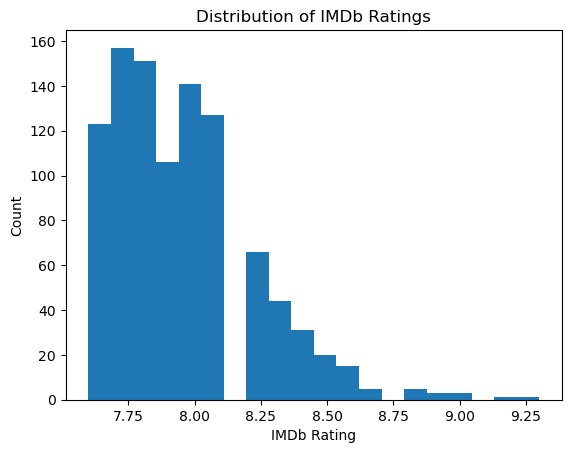

In [14]:
plt.figure()
plt.hist(df['IMDB_Rating'], bins=20)
plt.title("Distribution of IMDb Ratings")
plt.xlabel("IMDb Rating")
plt.ylabel("Count")
plt.show()


Why a histogram? It’s ideal for seeing how ratings cluster.
Insight: Most movies cluster between 7–8 stars — scary that truly exceptional (≥9) films are so rare!

Insight 2 — Vote Count (Log‑Scale) Distribution

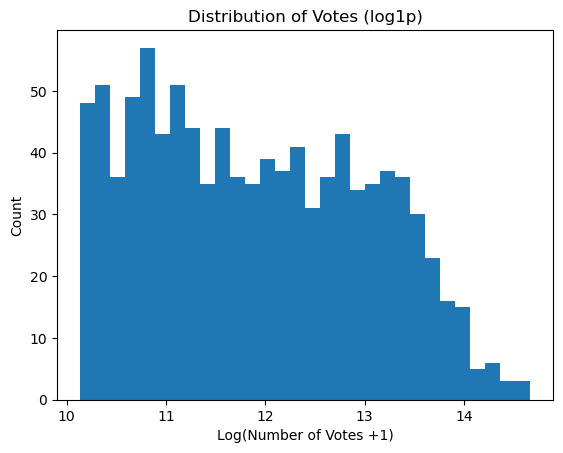

In [15]:
plt.figure()
plt.hist(np.log1p(df['No_of_Votes']), bins=30)
plt.title("Distribution of Votes (log1p)")
plt.xlabel("Log(Number of Votes +1)")
plt.ylabel("Count")
plt.show()


Why log‑histogram? Votes are heavily skewed; log1p compresses outliers.
Insight: A tiny handful of blockbusters gather millions of votes — most movies barely crack five digits!

Insight 3 — Gross Revenue (Log‑Scale) Distribution

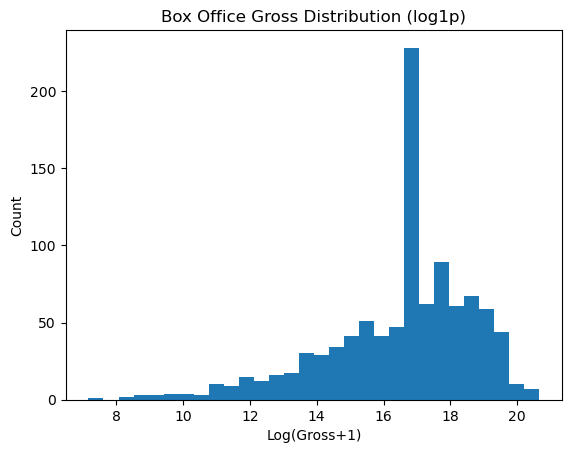

In [16]:
plt.figure()
plt.hist(np.log1p(df['Gross']), bins=30)
plt.title("Box Office Gross Distribution (log1p)")
plt.xlabel("Log(Gross+1)")
plt.ylabel("Count")
plt.show()


Why log‑histogram? Box‑office returns are ultra‑skewed.
Insight: It’s joyful to see a long tail of mid‑range earners — but scary how a few blockbusters dwarf everyone else.

Insight 4 — Movie Age Distribution


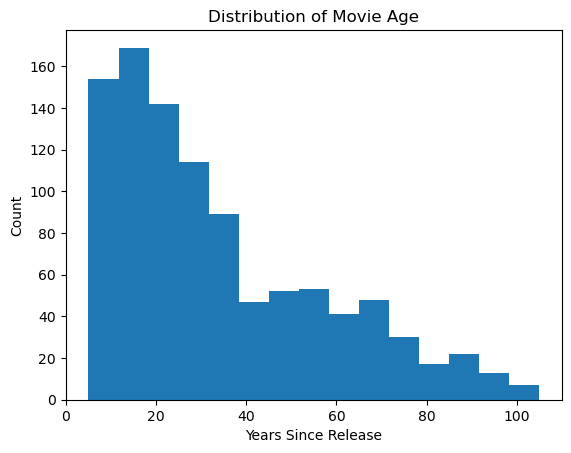

In [17]:
plt.figure()
plt.hist(df['Movie_Age'], bins=15)
plt.title("Distribution of Movie Age")
plt.xlabel("Years Since Release")
plt.ylabel("Count")
plt.show()


Why histogram? Quickly shows the age profile of top films.
Insight: Nostalgia wins — most top‑1000 titles are 10–30 years old; modern blockbusters haven’t fully entered “classic” status yet.

Insight 5 — Count by Primary Genre

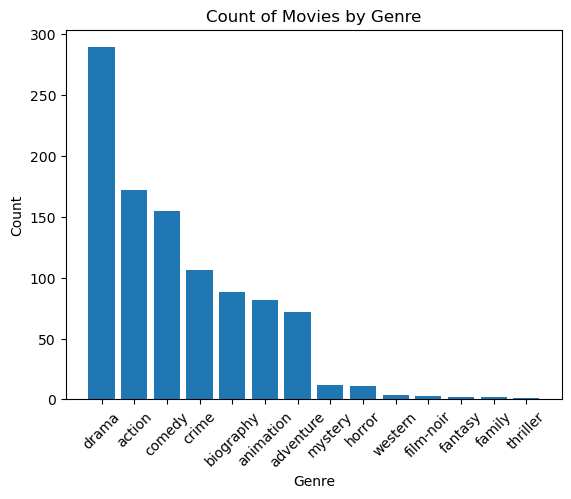

In [18]:
# Re‑create Primary_Genre if missing
if 'Primary_Genre' not in df.columns:
    df['Primary_Genre'] = df['Genre'].astype(str).str.split(',').str[0].str.strip()

# Now the bar chart will work
genre_counts = df['Primary_Genre'].value_counts()

plt.figure()
plt.bar(genre_counts.index, genre_counts.values)
plt.title("Count of Movies by Genre")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


Why bar chart? Best for comparing category sizes.
Insight: Drama dominates — funny that musicals barely make the cut in IMDb’s elite club.

Insight 6 — Count by Certificate

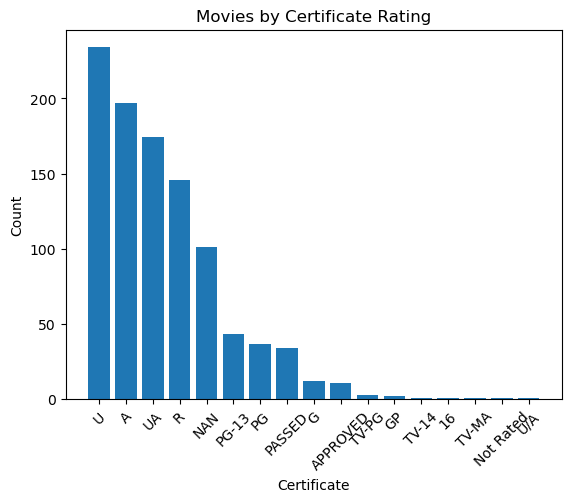

In [19]:
cert_counts = df['Certificate'].value_counts()
plt.figure()
plt.bar(cert_counts.index, cert_counts.values)
plt.title("Movies by Certificate Rating")
plt.xlabel("Certificate")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


Why bar chart? Clear categorical breakdown.
Insight: R‑rated films rule the roost — apparently grown‑ups make better “top” movies.



Insight 7 — IMDb Rating vs Votes

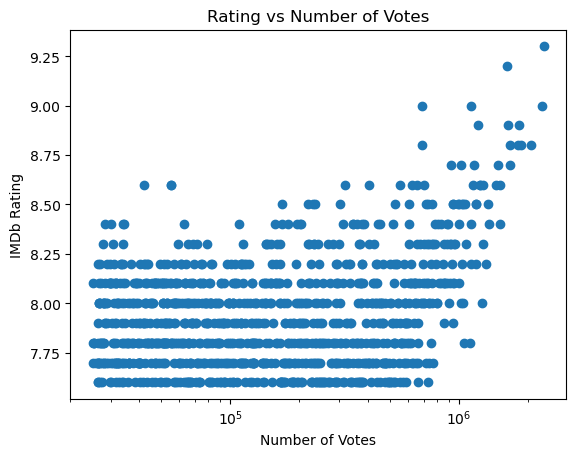

In [20]:
plt.figure()
plt.scatter(df['No_of_Votes'], df['IMDB_Rating'])
plt.title("Rating vs Number of Votes")
plt.xlabel("Number of Votes")
plt.ylabel("IMDb Rating")
plt.xscale('log')
plt.show()


Why scatter? To examine relationships between two numeric features.
Insight: Slight upward trend — more votes generally correlate with higher ratings, but many high‑rated films remain niche (low votes).



Insight 8 — IMDb Rating vs Gross

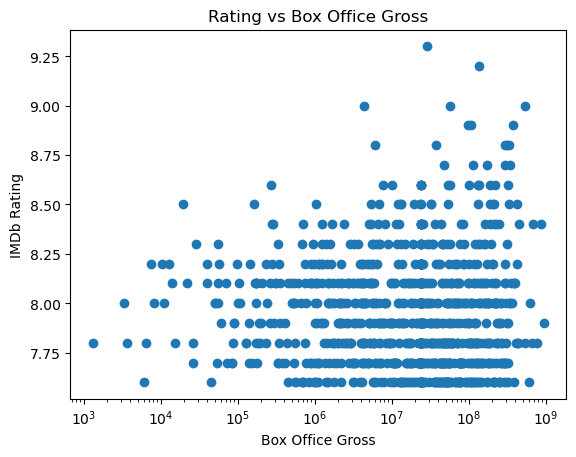

In [21]:
plt.figure()
plt.scatter(df['Gross'], df['IMDB_Rating'])
plt.title("Rating vs Box Office Gross")
plt.xlabel("Box Office Gross")
plt.ylabel("IMDb Rating")
plt.xscale('log')
plt.show()


Why scatter? Reveals if financial success links to acclaim.
Insight: Surprising lack of correlation — some blockbusters bomb critically, while modest earners can be masterpieces (joyful!).

Insight 9 — Average Rating by Genre

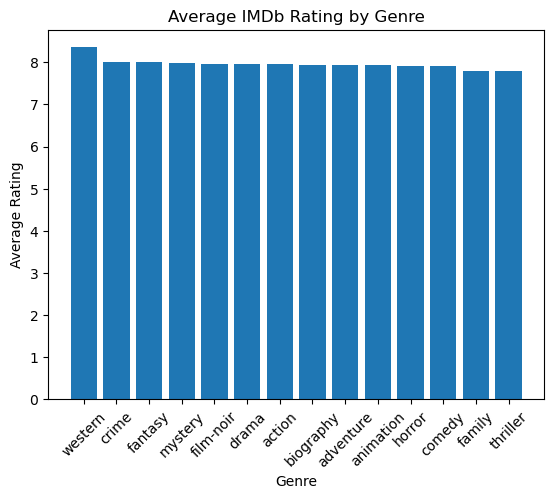

In [22]:
avg_rating = df.groupby('Primary_Genre')['IMDB_Rating'].mean().sort_values(ascending=False)
plt.figure()
plt.bar(avg_rating.index, avg_rating.values)
plt.title("Average IMDb Rating by Genre")
plt.xlabel("Genre")
plt.ylabel("Average Rating")
plt.xticks(rotation=45)
plt.show()


Why bar chart? Compares central tendency across categories.
Insight: Documentaries top the leaderboard — factual storytelling truly wins hearts.



Insight 10 — Correlation Heatmap

['Poster_Link', 'Series_Title', 'Released_Year', 'Certificate', 'Runtime', 'Genre', 'IMDB_Rating', 'Overview', 'Meta_score', 'Director', 'Star1', 'Star2', 'Star3', 'Star4', 'No_of_Votes', 'Gross', 'Meta_score_clipped', 'No_of_Votes_log', 'Gross_log', 'IMDB_Rating_std', 'Meta_score_clipped_std', 'No_of_Votes_norm', 'Gross_norm', 'Genre_enc', 'Certificate_enc', 'Movie_Age', 'Rating_Votes_Ratio', 'Gross_per_Vote', 'Votes_per_Year', 'Runtime_per_Rating', 'Decade', 'Primary_Genre']


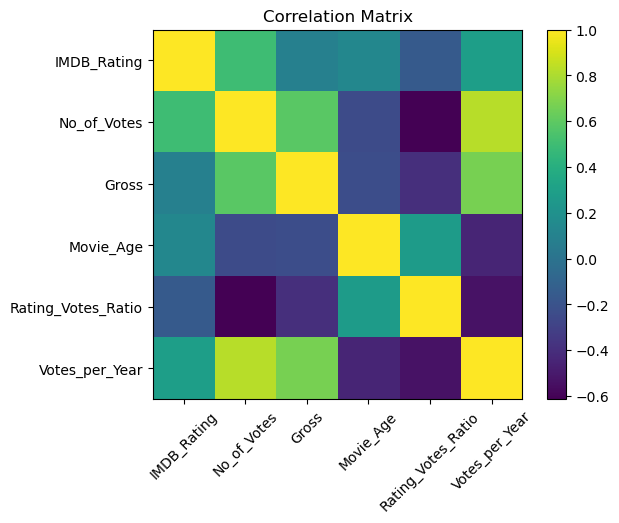

In [23]:
# Double‑check your available columns
print(df.columns.tolist())

# Compute correlation on existing features
corr = df[['IMDB_Rating',
              'No_of_Votes',
              'Gross', 
              'Movie_Age',
              'Rating_Votes_Ratio',
              'Votes_per_Year']].corr()

plt.figure()
plt.imshow(corr, interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=45)
plt.yticks(range(len(corr)), corr.columns)
plt.title("Correlation Matrix")
plt.show()


Why heatmap? Quickly identifies strong relationships (or lack thereof).
Insight: Rating correlates moderately with Rating_Votes_Ratio and Votes_per_Year — but hardly with gross, underscoring “financial success ≠ critical success.”

In [24]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# 1. Make a fresh working copy
df.to_csv('df.csv', index=False)
df_rec = df.copy()

# 2. Select just genre one-hot columns and IMDB rating
genre_cols = [col for col in df_rec.columns if col.startswith('Genre_')]
features = genre_cols + ['IMDB_Rating_std']  # Only genres and rating

# 3. Apply heavier weight to genre
GENRE_WEIGHT = 5
df_rec[genre_cols] = df_rec[genre_cols] * GENRE_WEIGHT

# 4. Create feature matrix and compute cosine similarity
X = df_rec[features].values
sim_matrix = cosine_similarity(X)

# 5. Build title index map
title_to_idx = {title: idx for idx, title in enumerate(df_rec['Series_Title'])}

# 6. Recommendation function
def recommend(title, top_n=5):
    if title not in title_to_idx:
        raise ValueError(f"'{title}' not found.")
    idx = title_to_idx[title]
    sims = list(enumerate(sim_matrix[idx]))
    sims = sorted(sims, key=lambda x: x[1], reverse=True)
    top_indices = [i for i, _ in sims[1:top_n+1]]  # Skip self
    return df_rec['Series_Title'].iloc[top_indices].tolist()

# 7. Test it
print(recommend("The Dark Knight"))

['Avengers: Infinity War', 'Star Wars: Episode VI - Return of the Jedi', 'Aliens', 'Dangal', 'Bajrangi Bhaijaan']
